# 05. K-nn Regression model with PCA
__Capstone project: Duration of the insertion of real estate advertisements for rental apartments in Switzerland__

I choose the k-nn model, as it is among the most popular machine learning algorithms, but not widly used for regression predictive problems. I'am simply interested in how the model performs.

Regarding the feature space, I want to use only the most informative features. I expect that if I include all independent variables in the regression equations, my model will tend to be unprecise. On the other hand, if I include too few variables, my model could be biased. For the k-nn model, I will select the most informative features by using a PCA method. With PCA, I will convert a set of possibly correlated features into linearly uncorrelated values. This helps me avoiding the curse of dimensionality by reducing information redundancy and data dimensionality. A dimensionality reduction technique prior to modeling is needed because k-nn models do not perform well with high dimensions where data points become very spread out. In addition, by reducing the dimensions, I will speed up the training process and make the computation less heavy and therfore faster.

For the k-nn model I will use the GridSearchCV technique to find the best k value (= number of neighbors), the weights (uniform or distance) and metrics (euclidean or manhattan). Again, I will use Cross Validation with K-Folds. I believe 5 iterations should be sufficient. I will standardize the data using StandardScaler and see is the standardization improves my results or not. 

## Import

In [1]:
# import commands
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Data/df_after_eda.csv", delimiter=",")

In [3]:
df.shape

(921886, 142)

## Split data

First I will load the features into a feature matrix X and the target value into an output vector y. 

In [4]:
X = df.drop("Insertionsdauer", axis=1).values
y = df["Insertionsdauer"].values

I decided to split my data 80% - 20%, because I have a lot of data points and the proportion of testing data should be enough. Furthermore I chose the number 8 for the the random_state, as it is my lucky number.

In [5]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=8)

In [6]:
print("Shape X_tr:", X_tr.shape)
print("Shape y_tr:", y_tr.shape)

Shape X_tr: (737508, 141)
Shape y_tr: (737508,)


## Downsampling training data 

Since my dataframe is very big, the calculation for the hyperparametertuning incl. CV and GridSearch takes a lot of time. Therefore I decided to downsample my training and validation data to something more manageable, yet representative, in order to identify suitable hyperparameters or a least the best range for the hyperparameters. I will use sklearn's resample method and keep 20'000 samples. I am not consernd about inbalanced categorical data, as my target is a numerical. Otherwise, I could use the arugment ``stratify`` to preserve the distribution in the original classes of a selected categorical feature. 

In [7]:
from sklearn.utils import resample, shuffle
X_tr_sample = resample(X_tr, random_state=8, n_samples=30000, replace=False)
X_tr_sample.shape

(30000, 141)

In [8]:
y_tr_sample = resample(y_tr, random_state=8, n_samples=30000, replace=False)
y_tr_sample.shape

(30000,)

## PCA

The idea behind PCA is to reduce the number of dimensions by projecting the data onto a set of n orthogonal axes, that capture as much of the variation in the data points as possible. Let's first have a look at how many PCA components explain how much of the variance by looking at a scree plot.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create Standard scaler
scaler = StandardScaler().fit(X_tr)

# Rescale data
X_tr_rescaled = scaler.transform(X_tr)

# Create PCA transformer
pca = PCA(random_state=8, n_components=None)

# Apply PCA
pca.fit(X_tr_rescaled, y=None)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

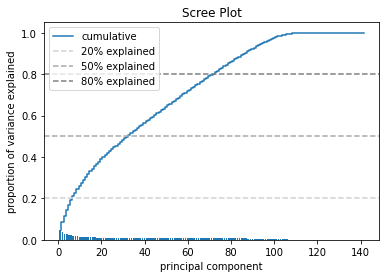

In [10]:
# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor + 0.5,  # 1.5,2.5,..,n_components+0.5
    pve_cumsum,  # Cumulative sum
    label="cumulative")

#plot line
plt.axhline(y = 0.2, color ="lightgrey", linestyle ="--", label ='20% explained',)
plt.axhline(y = 0.5, color ="darkgrey", linestyle ="--", label ='50% explained',)
plt.axhline(y = 0.8, color ="grey", linestyle ="--", label ='80% explained',)


# Add labels
plt.title('Scree Plot')
plt.xlabel("principal component")
plt.ylabel("proportion of variance explained")
plt.legend()
plt.show();

In [11]:
# Source: https://www.kaggle.com/code/pasqualebalsebre/a-ml-analysis-of-california-housing-data

totalvar = 0
for var in pca.explained_variance_:
    totalvar += var

# perc_var is the variance (%) for each feature
perc_var = pca.explained_variance_/totalvar*100

# here i build the cumulative var

cum_var = []

for i in range(0,len(perc_var)):
    cum_var.append(perc_var[i])

for i in range(0,len(perc_var)):
    for j in range(0,i):
        cum_var[i] = cum_var[i] + perc_var[j]

In [12]:
print('2 components explain %d%% of variance\n'%cum_var[1])
print('5 components explain %d%% of variance\n'%cum_var[4])
print('10 components explain %d%% of variance\n'%cum_var[9])
print('25 components explain %d%% of variance\n'%cum_var[24]) 
print('50 components explain %d%% of variance\n'%cum_var[49])
print('60 components explain %d%% of variance\n'%cum_var[59])

2 components explain 8% of variance

5 components explain 16% of variance

10 components explain 25% of variance

25 components explain 43% of variance

50 components explain 64% of variance

60 components explain 71% of variance



A good score would be around 70% of explained varianced, that would meen I have to use around 65 components.

## K-nn

__Number of neighbors:__

Choosing a small value of k will lead to overfitting. In contrast, choosing a large value will lead to underfitting and will be computationally expensive.

__Weights:__
* Uniform weights (default): each point in the local neighborhood contributes uniformly to the classification of a query point. 
* Distance weights: nearby points contribute more to the regression than faraway points. The weight is proportional to the inverse of the distance from the query point. 

__Metric:__
* Euclidean distance: (default metric that Scikit learn): It is a measure of the true straight line distance between two points in Euclidean space. Data has to be normalized or standardized. _sqrt(sum((x - y)^2))_
* Manhattan distance: "city block distance", the distance between two points is the sum of the absolute differences of their Cartesian coordinates. _sum(|x - y|)_

### Hyperparameter tuning with sample data

In [13]:
from sklearn import decomposition
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### neighbors and PCA

In [14]:
# Create pipeline with StandardScaler and PCA
pipe_knn = Pipeline(steps=[("scaler", StandardScaler()), # Standardize features before k-NN
                           ("pca", PCA()),
                           ("knn", KNeighborsRegressor())])


In [15]:
# define range of n_neighbors
grid01 = {"knn__n_neighbors": [5, 25, 50, 100, 150, 200, 250],
         "pca__n_components": [2, 10, 25, 50, 65, 80],}

# Grid search with cross-validation
grid_knn01 = GridSearchCV(pipe_knn, grid01, return_train_score=True, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, cv=5)

# fit
grid_knn01.fit(X_tr_sample, y_tr_sample)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [5, 25, 50, 100, 150, 200, 250],
                         'pca__n_components': [2, 10, 25, 50, 65, 80]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [16]:
grid_knn01.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'param_pca__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [17]:
# view the results as a pandas DataFrame
results01 = pd.DataFrame(grid_knn01.cv_results_)[['mean_test_score', 'std_test_score',
                                              'mean_train_score', 'std_train_score',  
                                             'rank_test_score', 'param_knn__n_neighbors', 'param_pca__n_components']]

# show results 
results01.sort_values(by="rank_test_score").head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score,param_knn__n_neighbors,param_pca__n_components
14,-0.873184,0.011864,-0.855849,0.002933,1,50,25
20,-0.873811,0.011039,-0.865034,0.002376,2,100,25
15,-0.874501,0.011060,-0.856963,0.002105,3,50,50
21,-0.874599,0.011551,-0.865467,0.002895,4,100,50
26,-0.874833,0.010516,-0.869146,0.002779,5,150,25


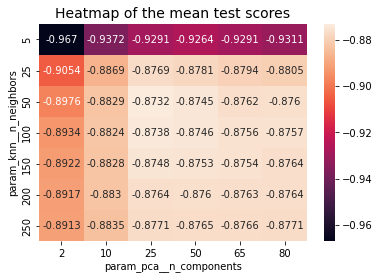

In [18]:
# Source: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
max_scores = results01.groupby(['param_knn__n_neighbors', 
                                    'param_pca__n_components']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

plt.title("Heatmap of the mean test scores", fontsize=14)
plt.show()

This heatmap shows that with only 5 neighbors the model gives the bad scores. With around 25-50 neighbors, the scores are better and don't get any better with more neighbors. For the components the same is true: from 25 components on the scores are good and don't get any better with more components. 

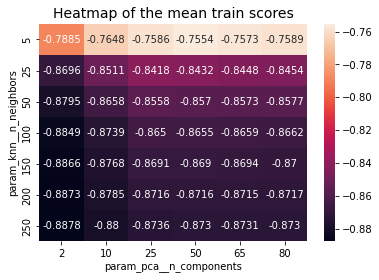

In [19]:
# Source: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

plt.title("Heatmap of the mean train scores", fontsize=14)
plt.show()

The heatmap for the mean train scores show a different picture: With only 5 neighbors I get the best scores.neighbors_te_mean

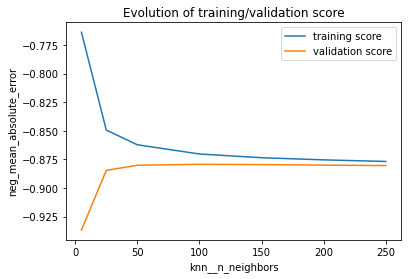

In [20]:
# calculate mean groubed by parameter
mean_neighbors = results01.groupby(['param_knn__n_neighbors']).mean()

# plot
plt.plot(list(mean_neighbors.index),mean_neighbors['mean_train_score'], label='training score')
plt.plot(list(mean_neighbors.index),mean_neighbors['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("knn__n_neighbors")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

Between 5 and 20 neighbors, the training score is low and the validation score is high, the estimator is overfitting. The algorithm captures well the training data, but it performs poorly on the validation data as it is not able to generalize. In general, with overfitting the model is too complex and fits the noise in addition to the signal.

With a higher number of neighbors, the validation score and the training score converge to a similar value with increasing number of neighbors. Thus, the model would probably not benefit much from more neighbors.

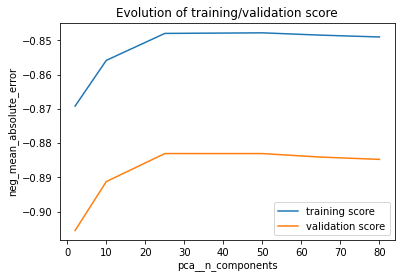

In [21]:
# calculate mean groubed by parameter
mean_components = results01.groupby(['param_pca__n_components']).mean()

# plot
plt.plot(list(mean_components.index),mean_components['mean_train_score'], label='training score')
plt.plot(list(mean_components.index),mean_components['mean_test_score'], label='validation score')

# labels & title
plt.ylabel("neg_mean_absolute_error")
plt.xlabel("pca__n_components")
plt.title("Evolution of training/validation score")
plt.legend()
plt.show()

The training curve and validation both start at a high score and soon improve with about 25 components. Then they've reached a plateau and there is no further improvement. The training curve is better then the validation curve, which is again a sign of overfitting. 

In [22]:
print("With my downsampled data, the best number of neighbors and components is {:}".format(grid_knn01.best_params_),
      "and the best MAE score is {:.3f}.".format(grid_knn01.best_score_))

With my downsampled data, the best number of neighbors and components is {'knn__n_neighbors': 50, 'pca__n_components': 25} and the best MAE score is -0.873.


#### weights

In [23]:
# define range of weights
grid03 = {"knn__n_neighbors": [50],
          "pca__n_components": [25],
          "knn__weights": ["uniform", "distance"],}

#Grid search with cross-validation
grid_knn03 = GridSearchCV(pipe_knn, grid03, return_train_score=True, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, cv=5)

grid_knn03.fit(X_tr_sample, y_tr_sample)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [50],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [25]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [24]:
# view the results as a pandas DataFrame
results03 = pd.DataFrame(grid_knn03.cv_results_)[['mean_test_score', 'std_test_score',
                                              'mean_train_score', 'std_train_score',  
                                             'rank_test_score', 'param_knn__weights']]

# show results 
results03.sort_values(by="rank_test_score")

,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score,param_knn__weights
1,-0.871679,0.009799,-0.711832,0.004840,1,distance
0,-0.874870,0.010960,-0.855918,0.003103,2,uniform


The mean test score is very similar for both ``distance`` and ``uniform``, however the mean train score clearly shows that ``distance`` gives the better performance.

In [25]:
grid_knn03.best_params_

{'knn__n_neighbors': 50, 'knn__weights': 'distance', 'pca__n_components': 25}

#### metrics

In [26]:
# define range of weights
grid04 = {"knn__n_neighbors": [50],
          "pca__n_components": [25],
          "knn__weights": ["distance"],
          "knn__metric": ["euclidean", "manhattan"],}

#Grid search with cross-validation
grid_knn04 = GridSearchCV(pipe_knn, grid04, return_train_score=True, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, cv=5)

grid_knn04.fit(X_tr_sample, y_tr_sample)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [50], 'knn__weights': ['distance'],
                         'pca__n_components': [25]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [27]:
# view the results as a pandas DataFrame
results04 = pd.DataFrame(grid_knn04.cv_results_)[['mean_test_score', 'std_test_score',
                                              'mean_train_score', 'std_train_score',  
                                             'rank_test_score', 'param_knn__metric']]

# show results 
results04.sort_values(by="rank_test_score")

,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score,param_knn__metric
0,-0.871974,0.010147,-0.707679,0.002646,1,euclidean
1,-0.872606,0.011146,-0.693094,0.004380,2,manhattan


For ``manhattan`` and ``euclidean`` the mean test score is very close, as is the mean train score. The improvement of the ``manhattan`` metric to the ``euclidean`` metric is negligible.

In [28]:
grid_knn04.best_params_

{'knn__metric': 'euclidean',
 'knn__n_neighbors': 50,
 'knn__weights': 'distance',
 'pca__n_components': 25}

### K-nn with the ~~whole~~ training data

When I try to train my model with the whole training dataset of 761'907 rows, my model will calculate forever without ever giving any results for the predictions. As I do not have access to more computational power, I decided to only use a subset of my data with 100'000 rows to make my predictions (100'000 row for the train data, 20'000 for the test data to have the same split of 80% - 20%). This problem shows that knn is not the best model chosen for my type of data.

In [29]:
from sklearn.utils import resample, shuffle
X_te_subset = resample(X_te, random_state=8, n_samples=20000, replace=False)
y_te_subset = resample(y_te, random_state=8, n_samples=20000, replace=False)

X_tr_subset = resample(X_tr, random_state=8, n_samples=100000, replace=False)
y_tr_subset = resample(y_tr, random_state=8, n_samples=100000, replace=False)

In [30]:
# Create the estimator
grid_knn = make_pipeline(StandardScaler(),
                         PCA(n_components=25),
                         KNeighborsRegressor(n_neighbors=50, weights="distance", metric="euclidean"))
                    
# Fit it to train data
grid_knn.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=25)),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=50,
                                     weights='distance'))])

#### Evaluation and predictions

In [31]:
# make prediction on test and train set
y_te_pred = grid_knn.predict(X_te_subset)

In [32]:
y_tr_pred = grid_knn.predict(X_tr_subset)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# calculate mae, mse, rmse and R2 for train data
print('Train set evaluation:\n_____________________________________')
print("MAE: {:.3f}".format(mean_absolute_error(y_tr_subset, y_tr_pred)))
print("MSE: {:.3f}".format(mean_squared_error(y_tr_subset, y_tr_pred)))
print("RMSE: {:.3f}".format(sqrt((mean_squared_error(y_tr_subset, y_tr_pred)))))
print("R2: {:.3f}".format(grid_knn.score(X_tr_subset, y_tr_subset)))

# calculate mae, mse, rmse and R2 for test data
print('\nTest set evaluation:\n_____________________________________')
print("MAE: {:.3f}".format(mean_absolute_error(y_te_subset, y_te_pred)))
print("MSE: {:.3f}".format(mean_squared_error(y_te_subset, y_te_pred)))
print("RMSE: {:.3f}".format(sqrt(mean_squared_error(y_te_subset, y_te_pred))))
print("R2: {:.3f}".format(grid_knn.score(X_te_subset, y_te_subset)))

Train set evaluation:
_____________________________________
MAE: 0.743
MSE: 0.836
RMSE: 0.914
R2: 0.323

Test set evaluation:
_____________________________________
MAE: 0.852
MSE: 1.095
RMSE: 1.047
R2: 0.111


## Export

In [34]:
# Export model predictions
predictions = pd.DataFrame({'Model': 'knn',
                            'True Value': np.exp(y_te_subset),
                            'Prediction': np.exp(y_te_pred),
                           'Error': np.exp(y_te_subset) - np.exp(y_te_pred)})

predictions.to_csv("ML_predictions_knn.csv", encoding='utf-8', index=False)

In [35]:
# Export model predictions
predictions = pd.DataFrame({'Model': 'knn',
                            'True Value': np.exp(y_tr_subset),
                            'Prediction': np.exp(y_tr_pred),
                           'Error': np.exp(y_tr_subset) - np.exp(y_tr_pred)})

predictions.to_csv("ML_predictions_knn_train.csv", encoding='utf-8', index=False)

In [36]:
# Export model evaluation
# Source: https://www.geeksforgeeks.org/how-to-append-a-new-row-to-an-existing-csv-file/

# Import writer class from csv module
from csv import writer
 
# List that we want to add as a new row
List = ['K-nn', mean_absolute_error(y_te_subset, y_te_pred), mean_squared_error(y_te_subset, y_te_pred),
                          sqrt((mean_squared_error(y_te_subset, y_te_pred))), grid_knn.score(X_te_subset, y_te_subset)]
 
# Open our existing CSV file in append mode
# Create a file object for this file
with open('ML_evaluations.csv', 'a') as f_object:
 
    # Pass this file object to csv.writer()
    # and get a writer object
    writer_object = writer(f_object)
 
    # Pass the list as an argument into
    # the writerow()
    writer_object.writerow(List)
 
    # Close the file object
    f_object.close()